# Kopp et al 2021 Evaluation 
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to perform a brief evaluation of trained models on the Kopp21 et al dataset.
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Global seed set to 13
2022-08-25 16:17:19.914222: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 16:17:19.914265: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/workspaces/EUGENe/eugene/external/kipoi_veff/seqplotting_deps.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/workspaces/EUGENe/eugene/external/kipoi_veff/seqplotting_deps.py:37: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of N

In [2]:
eu.settings.dataset_dir = "../../../_data/eugene/kopp21"
eu.settings.output_dir = "../../../_output/kopp21"
eu.settings.logging_dir = "../../../_logs/kopp21"
eu.settings.config_dir = "../../../_configs/kopp21"
figure_dir = "../../../_figures/kopp21"
eu.settings.verbosity = logging.ERROR
eu.settings.batch_size = 128
eu.settings.dl_num_workers = 0

# Load in the `leaf`, `proto` and `combined` test `SeqData`s 

In [3]:
# Load in the preprocessed training data
#sdata_sub = eu.dl.read_h5sd(os.path.join(eu.settings.output_dir, "train_sub_predictions.h5sd"))
sdata_sub = eu.dl.read_h5sd(
    filename="../../../_data/jund_processed_sub.h5sd",
)
sdata_sub.make_names_unique()
sdata_sub

SeqData object with = 2000 seqs
seqs = (2000,)
names = (2000,)
rev_seqs = (2000,)
ohe_seqs = (2000, 500, 4)
ohe_rev_seqs = (2000, 500, 4)
seqs_annot: 'chr', 'end', 'seq_len', 'start', 'target'
pos_annot: None
seqsm: None
uns: None

In [4]:
# Split into train and test sets
eu.pp.train_test_split_data(
    sdata_sub, 
    train_key="train_val",
    chr = ["chr3"]
)
sdata_sub = eu.dl.concat([sdata_sub[sdata_sub["train_val"]][:90], sdata_sub[~sdata_sub["train_val"]][:10]], keys=["train", "val"])
sdata_sub["train_val"].value_counts()

SeqData object modified:
    seqs_annot:
        + train_val


True     90
False    10
Name: train_val, dtype: int64

# Get test set predictions for each model

In [5]:
# Predict on test set with each model
model_types = ["FCN", "CNN", "RNN", "Hybrid", "Kopp21CNN"]
model_names = ["dsFCN", "dsCNN", "dsRNN", "dsHybrid", "Kopp21CNN"]
trials = 5
for model_name, model_type in zip(model_names, model_types):
    for trial in range(1, trials+1):
        print(f"{model_name} trial {trial}")
        model_file = glob.glob(os.path.join(eu.settings.logging_dir, model_name, f"test_trial_{trial}", "checkpoints", "*"))[0]
        if model_type == "FCN":
            model = eu.models.FCN.load_from_checkpoint(model_file)
        if model_type == "CNN":
            model = eu.models.CNN.load_from_checkpoint(model_file)
        if model_type == "RNN":
            model = eu.models.RNN.load_from_checkpoint(model_file)
        elif model_type == "Hybrid":
            model = eu.models.Hybrid.load_from_checkpoint(model_file)
        elif model_type == "Kopp21CNN":
            model = eu.models.Kopp21CNN.load_from_checkpoint(model_file)
        if model_type == "RNN":
            t_kwargs = transform_kwargs={"transpose": False}
        else:
            t_kwargs = transform_kwargs={"transpose": True}
        eu.predict.predictions(
            model,
            sdata=sdata_sub,
            target="target",
            name=model_name,
            transform_kwargs=t_kwargs,
            version=f"test_trial_{trial}",
            file_label="test",
            prefix=f"{model_name}_test_trial_{trial}_"
        )
        del model
sdata_sub.write_h5sd(os.path.join(eu.settings.output_dir, "test_sub_predictions.h5sd"))

dsFCN trial 1


/home/vscode/.local/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


No transforms given, assuming just need to tensorize).


/home/vscode/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `predict_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,
/home/vscode/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsFCN_test_trial_1_target_predictions
dsFCN trial 2
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + dsFCN_test_trial_2_target_predictions
dsFCN trial 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + dsFCN_test_trial_3_target_predictions
dsFCN trial 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + dsFCN_test_trial_4_target_predictions
dsFCN trial 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + dsFCN_test_trial_5_target_predictions
dsCNN trial 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsCNN_test_trial_1_target_predictions
dsCNN trial 2
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsCNN_test_trial_2_target_predictions
dsCNN trial 3
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsCNN_test_trial_3_target_predictions
dsCNN trial 4
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsCNN_test_trial_4_target_predictions
dsCNN trial 5
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsCNN_test_trial_5_target_predictions
dsRNN trial 1
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsRNN_test_trial_1_target_predictions
dsRNN trial 2
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsRNN_test_trial_2_target_predictions
dsRNN trial 3
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsRNN_test_trial_3_target_predictions
dsRNN trial 4
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsRNN_test_trial_4_target_predictions
dsRNN trial 5
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsRNN_test_trial_5_target_predictions
dsHybrid trial 1
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsHybrid_test_trial_1_target_predictions
dsHybrid trial 2
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsHybrid_test_trial_2_target_predictions
dsHybrid trial 3
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsHybrid_test_trial_3_target_predictions
dsHybrid trial 4
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsHybrid_test_trial_4_target_predictions
dsHybrid trial 5
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + dsHybrid_test_trial_5_target_predictions
Kopp21CNN trial 1
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + Kopp21CNN_test_trial_1_target_predictions
Kopp21CNN trial 2
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + Kopp21CNN_test_trial_2_target_predictions
Kopp21CNN trial 3
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + Kopp21CNN_test_trial_3_target_predictions
Kopp21CNN trial 4
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + Kopp21CNN_test_trial_4_target_predictions
Kopp21CNN trial 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + Kopp21CNN_test_trial_5_target_predictions


# Generate performance figures

In [47]:
from sklearn.metrics import precision_score

In [50]:
sdataframe = sdata_sub.seqs_annot
true = sdata_sub["target"]
prediction_labels = (sdataframe.columns[sdataframe.columns.str.contains("predictions")])
predicts = sdataframe[prediction_labels]
predicts = (predicts >= 0).astype(int)
scores = pd.DataFrame()
scores = pd.concat(
                [
                    scores,
                    predicts.apply(lambda x: precision_score(true, x), axis=0).to_frame(
                        name="precision"
                    ),
                ],
                axis=1,
            )

/home/vscode/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vscode/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vscode/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vscode/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetri

In [51]:
predicts

,dsFCN_test_trial_1_target_predictions,dsFCN_test_trial_2_target_predictions,dsFCN_test_trial_3_target_predictions,dsFCN_test_trial_4_target_predictions,dsFCN_test_trial_5_target_predictions,dsCNN_test_trial_1_target_predictions,dsCNN_test_trial_2_target_predictions,dsCNN_test_trial_3_target_predictions,dsCNN_test_trial_4_target_predictions,dsCNN_test_trial_5_target_predictions,...,dsHybrid_test_trial_1_target_predictions,dsHybrid_test_trial_2_target_predictions,dsHybrid_test_trial_3_target_predictions,dsHybrid_test_trial_4_target_predictions,dsHybrid_test_trial_5_target_predictions,Kopp21CNN_test_trial_1_target_predictions,Kopp21CNN_test_trial_2_target_predictions,Kopp21CNN_test_trial_3_target_predictions,Kopp21CNN_test_trial_4_target_predictions,Kopp21CNN_test_trial_5_target_predictions
seq0000,0,0,0,0,0,1,1,1,1,1,...,1,1,1,0,0,1,1,0,1,0
seq0001,0,0,0,0,0,1,1,1,1,1,...,1,1,1,0,0,1,1,0,1,0
seq0002,0,0,0,0,0,1,1,1,1,1,...,1,1,1,0,0,1,1,0,1,0
seq0003,0,0,0,0,0,1,1,1,1,1,...,1,1,1,0,0,1,1,0,1,0
seq0005,0,0,0,0,0,1,1,1,1,1,...,1,1,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seq0072,0,0,0,0,0,1,1,1,1,1,...,1,1,1,0,0,1,1,0,1,0
seq0181,0,0,0,0,0,1,1,1,1,1,...,1,1,1,0,0,1,1,0,1,0
seq0191,0,0,0,0,0,1,1,1,1,1,...,1,1,1,0,0,1,1,0,1,0
seq0215,0,0,0,0,0,1,1,1,1,1,...,1,1,1,0,0,1,1,0,1,0


/home/vscode/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vscode/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vscode/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vscode/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetri

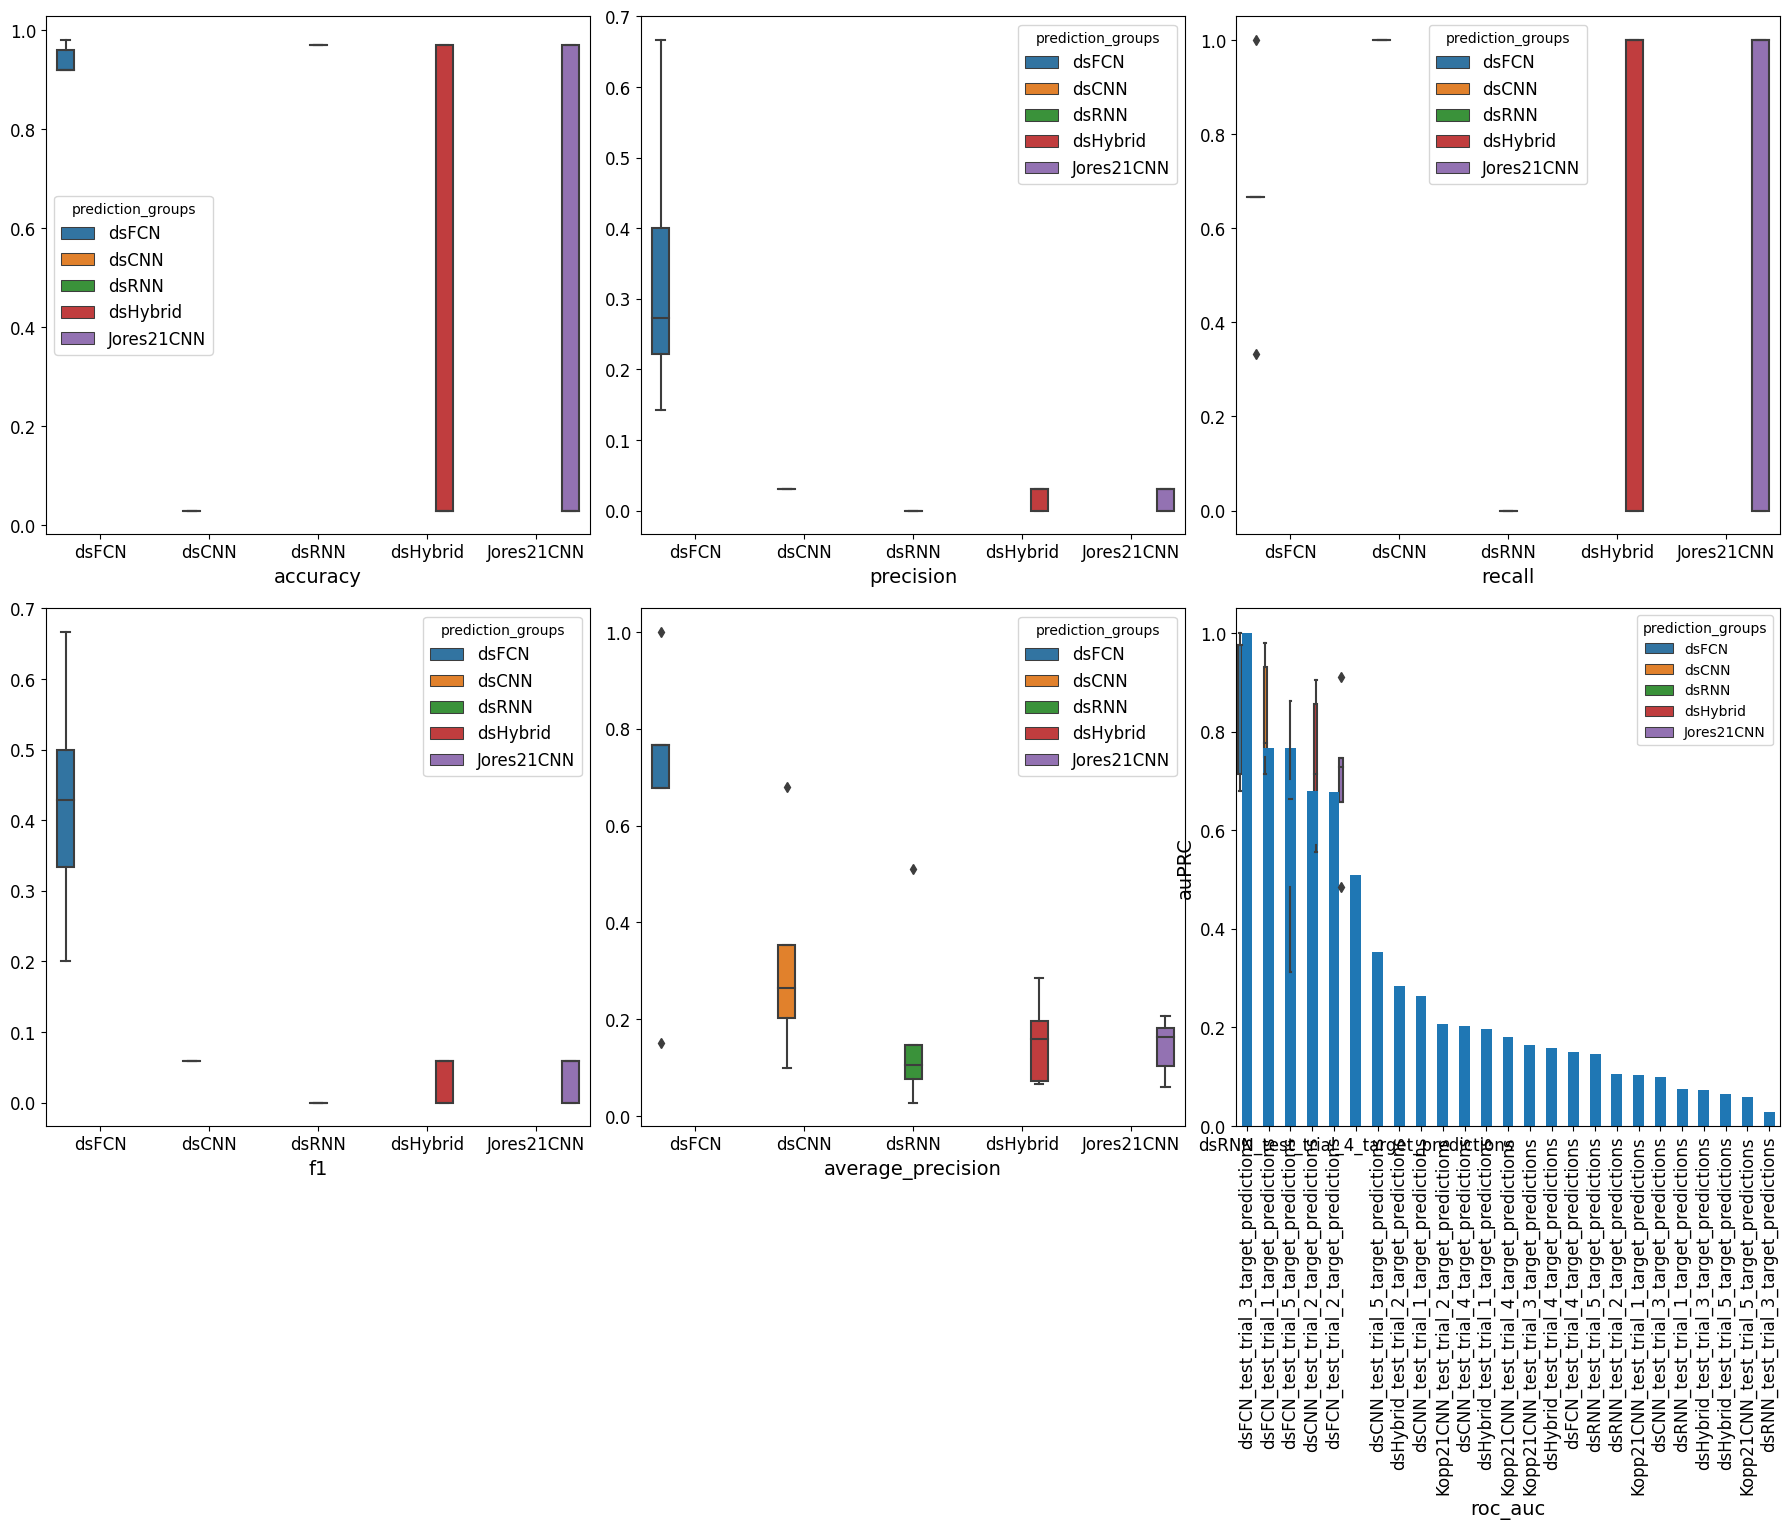

In [73]:
# Summarize performance across models for a metric
model_scores = eu.pl.performance_summary(
    sdata_sub,
    target="target",
    prediction_groups=["dsFCN"]*5 + ["dsCNN"]*5 + ["dsRNN"]*5 + ["dsHybrid"]*5 + ["Jores21CNN"]*5,
    hue="prediction_groups",
    metrics=["accuracy", "precision", "recall", "f1", "average_precision", "roc_auc"],
    figsize=(6, 6)
)

# Identify the best model from returned model scores
auprc_sorted = model_scores["average_precision"].sort_values(ascending=False)
auprc_sorted.plot(kind="bar", ylabel="auPRC")
plt.savefig(os.path.join(figure_dir, "performance_summary.png"))
plt.show()

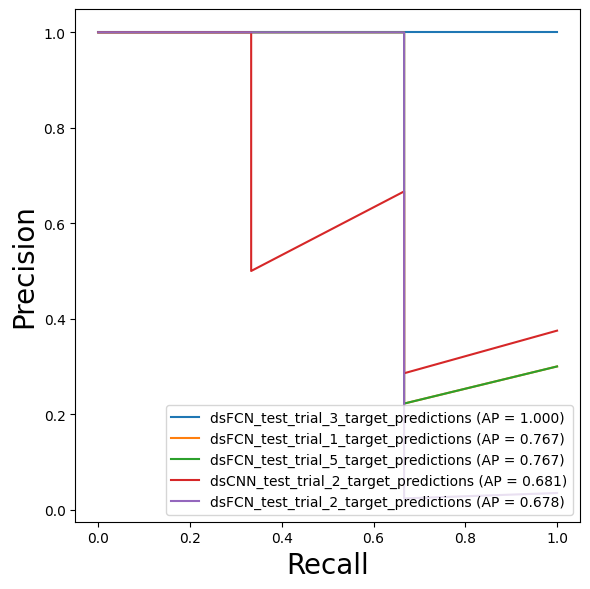

In [75]:
# Plot the performances across species for the best model
best_preds = auprc_sorted.index[:5]
eu.pl.auprc(
    sdata_sub, 
    targets=["target"]*5, 
    predictions=best_preds,
    labels=best_preds,
)
plt.show()

---

# Scratch

In [ ]:
preds = sdata_sub["dsFCN_test_trial_2_target_predictions"].values.reshape(-1, 1)

In [ ]:
targets = sdata_sub["target"].values.reshape(-1, 1)

In [ ]:
from sklearn.metrics import average_precision_score

In [ ]:
average_precision_score(targets, preds)

0.6782945736434108